# Project: clôture des actions de Microsoft 


## Description du Problème :
 Le problème consiste à prédire les valeurs futures de clôture des actions de Microsoft en se basant sur les données historiques disponibles. Avec un ensemble de données comportant 1426 observations,

Le modèle de prédiction sera élaboré en se basant sur les données historiques des actions de Microsoft, couvrant la période allant du 1er mars 2017 jusqu'à la dernière observation disponible en date du 31 août 2022

In [ ]:
!pip install statsmodels

# Install specific version of the package
!pip install statsmodels==0.13.5

# Modèle **ARIMA** : Prédiction de la Clôture des Prix de Microsoft

Le modèle *AutoRegressive Integrated Moving Average* (ARIMA) est une méthode de prévision largement connue et utilisée pour la prédiction des séries temporelles. Les modèles ARIMA sont capables de capturer différentes structures temporelles standard dans les données de séries temporelles.

## Terminologie :
Décomposons ces termes :
  <ul>
    <li>**AR (Auto Régressif) :**</li>
      Signifie que le modèle utilise la relation dépendante entre une observation et un nombre prédéfini d'observations retardées (également appelées "délai" ou "lag").
    <li>**I (Intégré):**</li>
      Signifie que le modèle utilise la différenciation des observations brutes (par exemple, il soustrait une observation d'une observation au pas de temps précédent) afin de rendre la série temporelle stationnaire.
    <li>**MA (Moyenne Mobile):**</li>
      Signifie que le modèle exploite la relation entre l'erreur résiduelle et les observations.
  </ul>

Utilisons ces concepts pour mieux comprendre et prédire la clôture des prix des actions de Microsoft.


## Paramètres du Modèle :
- **p :** Le nombre d'observations de décalage (lag).
- **d :** Le degré de différenciation.
- **q :** La taille/largeur de la fenêtre de moyenne mobile.


# 1- Chargement de tous les modules nécessaires

In [2]:
# Basic python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ARIMA-related libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import  qqplot
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.tsa.arima_model import  ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
import warnings 
warnings.filterwarnings('ignore')

## 2- Chargement des données


In [4]:

data = pd.read_csv('MSFT.csv', index_col='Date', parse_dates=True)
data=data.resample("D").mean()
data=data.interpolate(method='linear')
data.reset_index(inplace=True)

len(data)

2067

## 2-1 La valeur cible à prédire sera la valeur de la clôture (Close) du cours de l'action

In [5]:
data = data[['Date', 'Close']]
data.to_csv('data.csv', index=False)
data

,Date,Close
0,2017-01-03,62.580002
1,2017-01-04,62.299999
2,2017-01-05,62.299999
3,2017-01-06,62.840000
4,2017-01-07,62.773333
...,...,...
2062,2022-08-27,267.136668
2063,2022-08-28,266.183339
2064,2022-08-29,265.230011
2065,2022-08-30,262.970001


# 2-2 Transformer les données en une série temporelle.

In [6]:
def parser(x):
     return pd.datetime.strptime(x, '%Y-%m-%d')
series =pd.read_csv('data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [7]:
series

Date
2017-01-03     62.580002
2017-01-04     62.299999
2017-01-05     62.299999
2017-01-06     62.840000
2017-01-07     62.773333
                 ...    
2022-08-27    267.136668
2022-08-28    266.183339
2022-08-29    265.230011
2022-08-30    262.970001
2022-08-31    261.470001
Name: Close, Length: 2067, dtype: float64

## 3- Preprocessing


### Afficher les premières lignes de la série temporelle

In [8]:
series.head()

Date
2017-01-03    62.580002
2017-01-04    62.299999
2017-01-05    62.299999
2017-01-06    62.840000
2017-01-07    62.773333
Name: Close, dtype: float64

### Afficher les dix dernières lignes de la série temporelle

In [9]:
series.tail(10)

Date
2022-08-22    277.750000
2022-08-23    276.440002
2022-08-24    275.790009
2022-08-25    278.850006
2022-08-26    268.089996
2022-08-27    267.136668
2022-08-28    266.183339
2022-08-29    265.230011
2022-08-30    262.970001
2022-08-31    261.470001
Name: Close, dtype: float64

###  Obtenir des informations sur la série temporelle

In [10]:
series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2067 entries, 2017-01-03 to 2022-08-31
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2067 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


### Vérifier les valeurs manquantes dans la série temporelle

In [11]:
series.isnull().sum()

0

### Remplir les valeurs manquantes

In [12]:
# fill missing values (if any)
series.fillna(method='ffill', inplace=True)
print("pas de valeur null dans la datasets ")

pas de valeur null dans la datasets 


# 4- Data analysis

### Afficher des statistiques descriptives pour la série temporelle

In [13]:
series.describe().T

count    2067.000000
mean      169.499898
std        82.421583
min        62.299999
25%        98.334999
50%       141.883331
75%       244.026253
max       343.109985
Name: Close, dtype: float64

- **count (effectif) :** Il y a un total de 2067 observations dans l'ensemble de données, indiquant le nombre total de mesures de clôture des actions.

- **mean (moyenne) :** La valeur moyenne des clôtures est d'environ 169.50. Cela donne une indication de la valeur moyenne des actions sur la période, suggérant un niveau moyen de prix de clôture.

- **std (écart type) :** L'écart type est d'environ 82.42, indiquant la dispersion ou la variabilité des valeurs de clôture par rapport à la moyenne. Un écart type plus élevé suggère une plus grande variabilité.

- **min (minimum) :** La valeur minimale des clôtures est d'environ 62.30, représentant le prix de clôture le plus bas observé dans l'ensemble de données.

- **25% (premier quartile) :** 25% des observations de clôture sont inférieures à 98.33. Cela donne une indication de la distribution des valeurs de clôture dans la partie inférieure de l'ensemble de données.

- **50% (deuxième quartile ou médiane) :** La médiane est d'environ 141.88, indiquant que la moitié des observations de clôture sont inférieures à cette valeur, et l'autre moitié est supérieure.

- **75% (troisième quartile) :** 75% des observations de clôture sont inférieures à 244.03. Cela donne une indication de la distribution des valeurs de clôture dans la partie supérieure de l'ensemble de données.

- **max (maximum) :** La valeur maximale des clôtures est d'environ 343.11, représentant le prix de clôture le plus élevé observé dans l'ensemble de données.


### Tracer la série temporelle

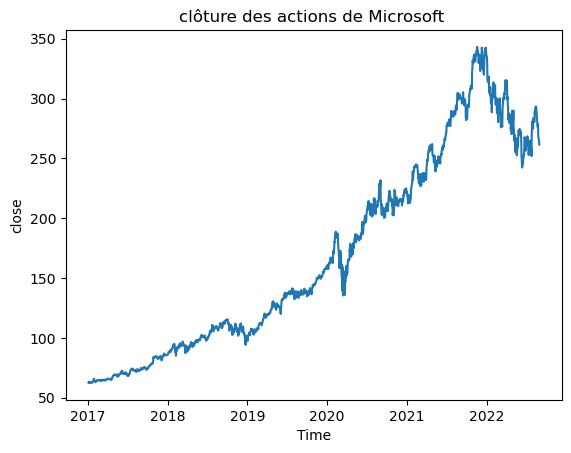

In [15]:
plt.plot(series)
plt.title('clôture des actions de Microsoft ')
plt.xlabel('Time')
plt.ylabel('close')
plt.show()

# Trend:
-------------
Le jeu de données présente une tendance croissante au fil des années pour les valeurs de clôture des actions de Microsoft


# Saisonnalité
------------
Le jeu de données présente une composante saisonnière au fil des années.

# Stationnarité?
-------------
Étant donné la présence du trend et de la saisonnalité, la série temporelle n'est probablement pas stationnaire.

## Tracé de l'histogramme
------

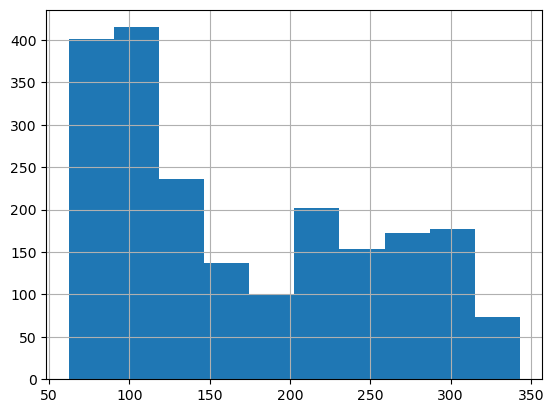

In [16]:
series.hist()

plt.show()

### Création d'un graphique de densité

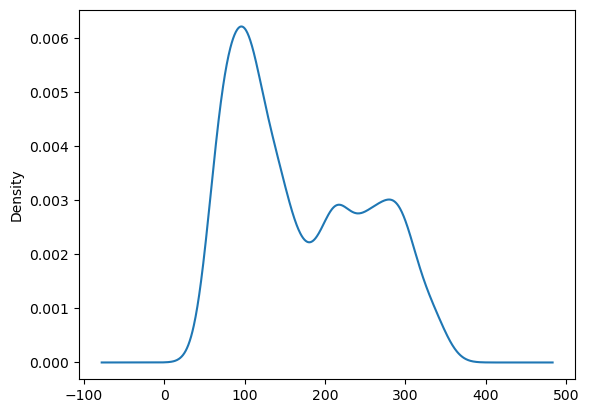

In [15]:
series.plot(kind='kde')
plt.show()

In [16]:
def parser(x):
     return pd.datetime.strptime(x, '%Y-%m-%d')
series =pd.read_csv('data.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

### Calculer les différences entre la moyenne de l'année en cours et la moyenne de l'année précédente

In [17]:
X = series.values
diff = list()
years_in_data = len(X)

for i in range(1, years_in_data):
    value = X[i] - X[i - 1]
    diff.append(value)


In [18]:
series

Date
2017-01-03     62.580002
2017-01-04     62.299999
2017-01-05     62.299999
2017-01-06     62.840000
2017-01-07     62.773333
                 ...    
2022-08-27    267.136668
2022-08-28    266.183339
2022-08-29    265.230011
2022-08-30    262.970001
2022-08-31    261.470001
Name: Close, Length: 2067, dtype: float64

### Tracer les différences

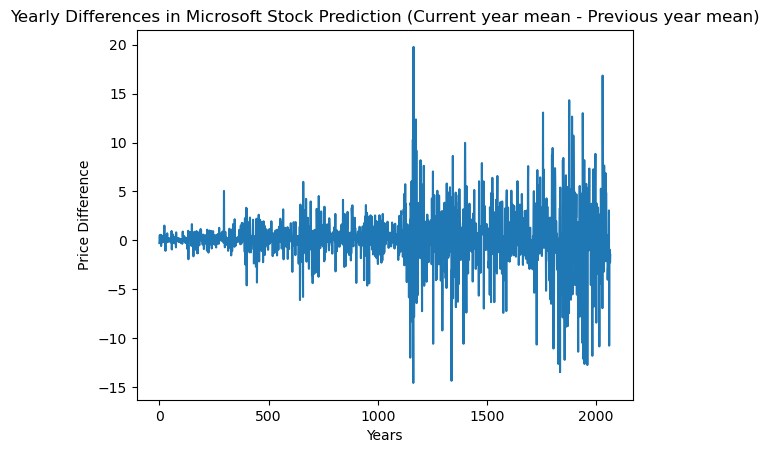

In [19]:
plt.plot(diff)
plt.title('Yearly Differences in Microsoft Stock Prediction (Current year mean - Previous year mean)')
plt.xlabel('Years')
plt.ylabel('Price Difference')
plt.show()

In [20]:
series.tail()

Date
2022-08-27    267.136668
2022-08-28    266.183339
2022-08-29    265.230011
2022-08-30    262.970001
2022-08-31    261.470001
Name: Close, dtype: float64

# Box and Whisker Plots by Interval
------


### Créer des groupes par mois pour les années 2017 à 2021

In [21]:
groups = series["2017":"2021"].resample('M').mean()
years = pd.DataFrame()
for name, group in groups.groupby(groups.index.year):
    years[name] = group.values.tolist()

### Boxplot

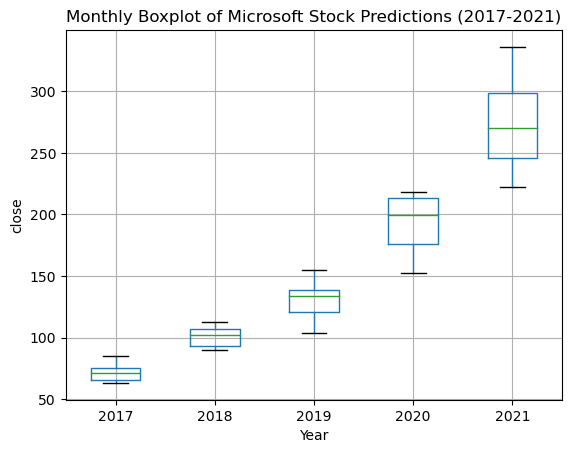

In [22]:
years.boxplot()
plt.title('Monthly Boxplot of Microsoft Stock Predictions (2017-2021)')
plt.xlabel('Year')
plt.ylabel('close')
plt.show()

### Créer des groupes par année pour l'année 2022

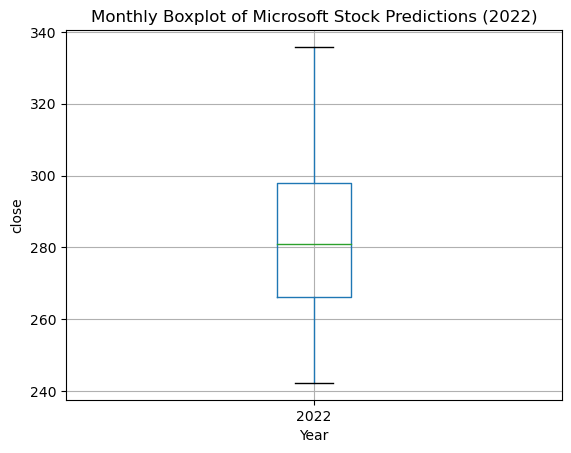

In [17]:
groups = series['2022'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.title('Monthly Boxplot of Microsoft Stock Predictions (2022)')
plt.xlabel('Year')
plt.ylabel('close')
plt.show()


------
# Modèles ARIMA
-------

### Test ADF (Augmented Dickey-Fuller)


In [24]:
# Drop any NaN values resulting fromdifferencing
series = series.dropna()

# Check for infinite values
if not np.isfinite(series).all():
    print("Data contains infinite values. Please handle them before running the ADF test.")
else:
    result = adfuller(series)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.743070
p-value: 0.835276
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### Différenciation

In [25]:
# Convertir les valeurs en numériques
series = pd.to_numeric(series, errors='coerce')

X = series.values

# Première différenciation
def difference(data):
    L = list()
    for i in range(1, len(data)):
        value = data[i] - data[i - 1]
        L.append(value)
    return pd.Series(L)

series = difference(X)

# interpretation
------
compte tenu de la statistique ADF très négative et de la valeur p très faible, et la statistique ADF étant plus négative que les valeurs critiques, vous disposez de preuves solides pour rejeter l'hypothèse nulle. Par conséquent, la série temporelle différenciée est probablement stationnaire.

<Figure size 1800x800 with 0 Axes>

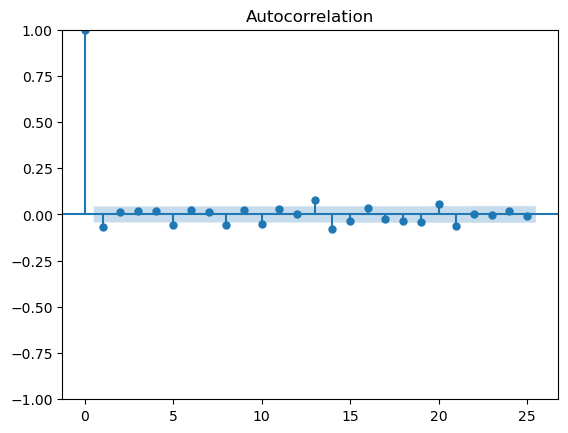

In [26]:
plt.figure(figsize=(18, 8))
plot_acf(series, lags=25)
plt.show()

In [ ]:
# Plot PACF with a larger number of lags
plot_pacf(series, lags=25)
plt.show()

In [27]:
len(series)

2066

# Choix Aléatoire des Paramètres ARIMA


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2067
Model:                ARIMA(11, 1, 3)   Log Likelihood               -4887.197
Date:                Sun, 28 Jan 2024   AIC                           9804.394
Time:                        21:48:36   BIC                           9888.894
Sample:                    01-03-2017   HQIC                          9835.370
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1023      0.093      1.098      0.272      -0.080       0.285
ar.L2         -0.1679      0.079     -2.134      0.033      -0.322      -0.014
ar.L3         -0.7454      0.081     -9.215      0.0

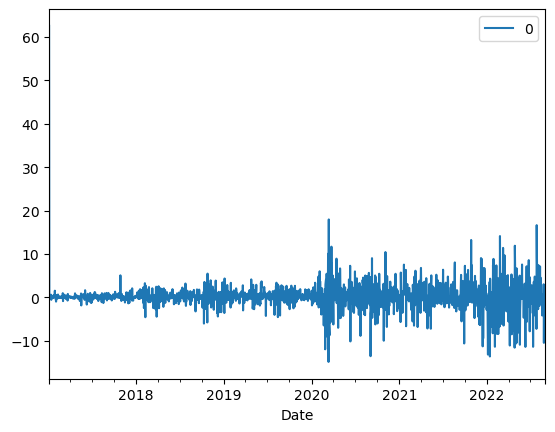

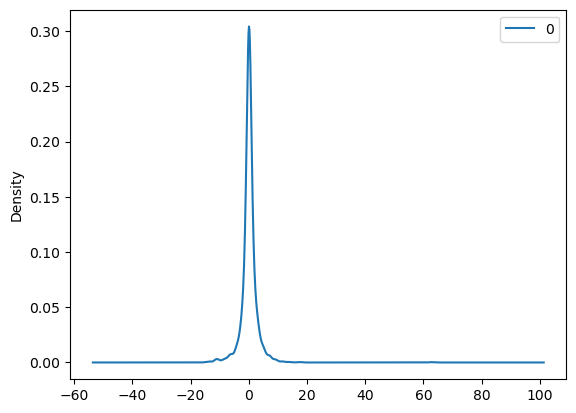

                 0
count  2067.000000
mean      0.132674
std       2.918498
min     -14.885466
25%      -0.617940
50%       0.064189
75%       0.883008
max      62.580002


In [19]:
from statsmodels.tsa.arima.model import ARIMA
# fit the ARIMA model
model = ARIMA(series, order=(11, 1, 3))
model_fit = model.fit()

# print summary
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [20]:
# Specify the start date for the forecast
start_date = '2022-09-01'  # Choose the date after March 8, 2022

# Generate date indices for the forecast
forecast_dates = pd.date_range(start=start_date, periods=10, freq='D')  # Adjust the frequency as needed

# Forecast future values
future_values = model_fit.forecast(steps=10)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'close': future_values})

# Display the forecast DataFrame
forecast_df


,Date,close
2022-09-01,2022-09-01,261.385185
2022-09-02,2022-09-02,261.119288
2022-09-03,2022-09-03,261.663204
2022-09-04,2022-09-04,261.418896
2022-09-05,2022-09-05,261.955658
2022-09-06,2022-09-06,261.571459
2022-09-07,2022-09-07,261.791112
2022-09-08,2022-09-08,261.521945
2022-09-09,2022-09-09,261.803131
2022-09-10,2022-09-10,261.768311


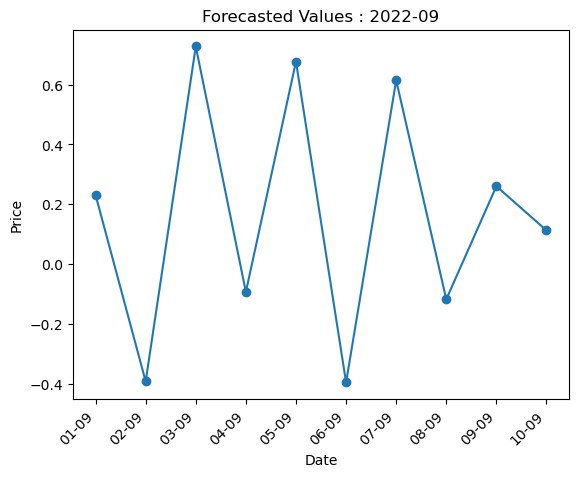

In [31]:
plt.plot(forecast_df['Date'], forecast_df['Forecast'], marker='o')
plt.title('Forecasted Values : 2022-09')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(forecast_df['Date'], [date.strftime('%d-%m') for date in forecast_df['Date']], rotation=45, ha='right')
plt.show()

In [32]:
series.tail()

2061   -0.953328
2062   -0.953328
2063   -0.953328
2064   -2.260010
2065   -1.500000
dtype: float64

### 1. Developing a manually configured ARIMA model.

### Model 1 

In [33]:
X=series.values
train_size = int(len(series) * 0.8)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions_model1 = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(11,1,3))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions_model1.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))


>Predicted=-0.263, Expected=1.530
>Predicted=-0.043, Expected=-1.480
>Predicted=0.229, Expected=-0.280
>Predicted=0.688, Expected=-1.247
>Predicted=0.117, Expected=-1.247
>Predicted=0.134, Expected=-1.247
>Predicted=0.495, Expected=2.310
>Predicted=-0.704, Expected=2.080
>Predicted=0.144, Expected=4.740
>Predicted=-0.671, Expected=3.530
>Predicted=0.250, Expected=-0.207
>Predicted=0.173, Expected=-0.207
>Predicted=0.412, Expected=-0.207
>Predicted=0.409, Expected=-2.510
>Predicted=-0.271, Expected=-0.320
>Predicted=0.434, Expected=0.280
>Predicted=-0.639, Expected=-1.590
>Predicted=0.422, Expected=-0.030
>Predicted=0.052, Expected=-0.030
>Predicted=0.288, Expected=-0.030
>Predicted=0.257, Expected=2.300
>Predicted=-0.169, Expected=-0.610
>Predicted=0.529, Expected=3.010
>Predicted=-0.349, Expected=-0.060
>Predicted=0.387, Expected=-0.377
>Predicted=0.189, Expected=-0.377
>Predicted=0.216, Expected=-0.377
>Predicted=0.187, Expected=-1.890
>Predicted=0.082, Expected=0.510
>Predicted=0.21

>Predicted=0.654, Expected=-1.210
>Predicted=0.528, Expected=-1.210
>Predicted=-0.855, Expected=10.710
>Predicted=0.332, Expected=7.240
>Predicted=-1.644, Expected=0.830
>Predicted=1.032, Expected=5.210
>Predicted=-0.549, Expected=-0.423
>Predicted=-0.055, Expected=-0.423
>Predicted=0.177, Expected=-0.423
>Predicted=-0.582, Expected=4.900
>Predicted=-0.309, Expected=-4.570
>Predicted=-0.308, Expected=4.610
>Predicted=0.102, Expected=-0.420
>Predicted=-0.101, Expected=2.340
>Predicted=-0.181, Expected=2.340
>Predicted=0.149, Expected=2.340
>Predicted=-0.251, Expected=4.710
>Predicted=-0.466, Expected=-1.550
>Predicted=0.626, Expected=-5.550
>Predicted=0.140, Expected=1.110
>Predicted=0.249, Expected=1.850
>Predicted=-0.885, Expected=1.850
>Predicted=0.506, Expected=1.850
>Predicted=-0.355, Expected=-4.090
>Predicted=0.720, Expected=-11.380
>Predicted=0.833, Expected=1.870
>Predicted=-0.121, Expected=-4.400
>Predicted=0.429, Expected=-3.903
>Predicted=-0.082, Expected=-3.903
>Predicted=1

In [34]:
# report performance
rmse = np.sqrt(mean_squared_error(test, predictions_model1))
print('RMSE Model 1: %.3f' % rmse)

RMSE Model 1: 4.210


# Grid search to find best configuration of ARIMA 
-------

In [35]:
import warnings 
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
# define range of p, d, q values to try
p_values = range(1, 12)
d_values = range(0, 2)
q_values = range(0, 3)

# grid search ARIMA parameters
best_aic, best_order = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(series, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic, best_order = model_fit.aic, (p, d, q)
                print('ARIMA%s AIC=%.3f' % ((p, d, q), model_fit.aic))
            except:
                continue
print('Best ARIMA%s AIC=%.3f' % (best_order, best_aic))

p, d, q = best_order


ARIMA(1, 0, 0) AIC=9812.405
ARIMA(1, 0, 1) AIC=9814.304
ARIMA(1, 0, 2) AIC=9816.188
ARIMA(1, 1, 0) AIC=10678.302
ARIMA(1, 1, 1) AIC=9816.430
ARIMA(1, 1, 2) AIC=9827.076
ARIMA(2, 0, 0) AIC=9814.253
ARIMA(2, 0, 1) AIC=9815.903
ARIMA(2, 0, 2) AIC=9796.828
ARIMA(2, 1, 0) AIC=10398.473
ARIMA(2, 1, 1) AIC=9818.257
ARIMA(2, 1, 2) AIC=9818.330
ARIMA(3, 0, 0) AIC=9815.460
ARIMA(3, 0, 1) AIC=9817.295
ARIMA(3, 0, 2) AIC=9807.493
ARIMA(3, 1, 0) AIC=10249.709
ARIMA(3, 1, 1) AIC=9819.423
ARIMA(3, 1, 2) AIC=9819.953
ARIMA(4, 0, 0) AIC=9816.443
ARIMA(4, 0, 1) AIC=9815.960
ARIMA(4, 0, 2) AIC=9795.066
ARIMA(4, 1, 0) AIC=10206.560
ARIMA(4, 1, 1) AIC=9820.360
ARIMA(4, 1, 2) AIC=9821.444
ARIMA(5, 0, 0) AIC=9812.009
ARIMA(5, 0, 1) AIC=9813.686
ARIMA(5, 0, 2) AIC=9819.983
ARIMA(5, 1, 0) AIC=10130.333
ARIMA(5, 1, 1) AIC=9816.038
ARIMA(5, 1, 2) AIC=9821.921
ARIMA(6, 0, 0) AIC=9813.353
ARIMA(6, 0, 1) AIC=9815.234
ARIMA(6, 0, 2) AIC=9799.074
ARIMA(6, 1, 0) AIC=10076.924
ARIMA(6, 1, 1) AIC=9817.345
ARIMA(6, 1, 2)

### Model 2 

In [36]:
X=series.values
train_size = int(len(series) * 0.8)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions_model2 = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(4,0,2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions_model2.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=-0.505, Expected=1.530
>Predicted=0.033, Expected=-1.480
>Predicted=0.414, Expected=-0.280
>Predicted=0.031, Expected=-1.247
>Predicted=0.425, Expected=-1.247
>Predicted=0.438, Expected=-1.247
>Predicted=0.381, Expected=2.310
>Predicted=-0.060, Expected=2.080
>Predicted=-0.086, Expected=4.740
>Predicted=-0.748, Expected=3.530
>Predicted=-0.284, Expected=-0.207
>Predicted=0.241, Expected=-0.207
>Predicted=0.051, Expected=-0.207
>Predicted=0.194, Expected=-2.510
>Predicted=0.557, Expected=-0.320
>Predicted=0.126, Expected=0.280
>Predicted=0.123, Expected=-1.590
>Predicted=0.440, Expected=-0.030
>Predicted=0.111, Expected=-0.030
>Predicted=0.150, Expected=-0.030
>Predicted=0.235, Expected=2.300
>Predicted=-0.163, Expected=-0.610
>Predicted=0.176, Expected=3.010
>Predicted=-0.203, Expected=-0.060
>Predicted=0.168, Expected=-0.377
>Predicted=0.235, Expected=-0.377
>Predicted=0.242, Expected=-0.377
>Predicted=0.166, Expected=-1.890
>Predicted=0.323, Expected=0.510
>Predicted=0.159

>Predicted=0.442, Expected=-1.210
>Predicted=-0.039, Expected=-1.210
>Predicted=0.035, Expected=10.710
>Predicted=-0.256, Expected=7.240
>Predicted=-0.884, Expected=0.830
>Predicted=-0.025, Expected=5.210
>Predicted=0.654, Expected=-0.423
>Predicted=-0.256, Expected=-0.423
>Predicted=-0.249, Expected=-0.423
>Predicted=0.986, Expected=4.900
>Predicted=-0.690, Expected=-4.570
>Predicted=-0.007, Expected=4.610
>Predicted=0.532, Expected=-0.420
>Predicted=0.219, Expected=2.340
>Predicted=-0.911, Expected=2.340
>Predicted=0.631, Expected=2.340
>Predicted=0.235, Expected=4.710
>Predicted=-1.059, Expected=-1.550
>Predicted=0.967, Expected=-5.550
>Predicted=0.916, Expected=1.110
>Predicted=-0.887, Expected=1.850
>Predicted=0.300, Expected=1.850
>Predicted=0.490, Expected=1.850
>Predicted=-0.570, Expected=-4.090
>Predicted=0.583, Expected=-11.380
>Predicted=1.548, Expected=1.870
>Predicted=-0.870, Expected=-4.400
>Predicted=0.279, Expected=-3.903
>Predicted=0.937, Expected=-3.903
>Predicted=0.8

In [37]:
rmse_model2 = np.sqrt(mean_squared_error(test, predictions_model2))
print('RMSE Model 2 : %.3f' % rmse_model2)

RMSE Model 2 : 4.125


### Erreur d'analyse du modèle 2

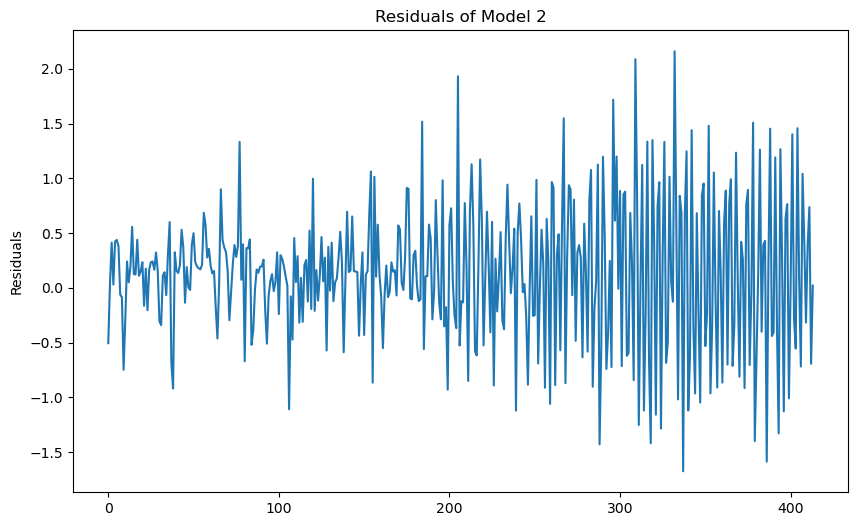

In [38]:

residuals_model2 = test - predictions_model2
plt.figure(figsize=(10, 6))
plt.plot(predictions_model2)
plt.title('Residuals of Model 2')

plt.ylabel('Residuals')
plt.show()

### Model 3

In [39]:
# Moyenne des erreurs pour le modèle 3
bias = np.mean(residuals_model2)

# Modèle 3 : Ajout de la moyenne des erreurs comme biais
predictions_model3 = predictions_model2 + bias
rmse_model3 = np.sqrt(mean_squared_error(test, predictions_model3))
print(f'Model 3 RMSE: {rmse_model3:.3f}')

# Comparaison des RMSE des modèles 2 et 3
print(f'Comparison of RMSEs: Model 2 RMSE = {rmse_model2:.3f}, Model 3 RMSE = {rmse_model3:.3f}')

Model 3 RMSE: 4.121
Comparison of RMSEs: Model 2 RMSE = 4.125, Model 3 RMSE = 4.121


In [40]:
print(f'Model 1 RMSE: 4.422')
print(f'Model 2 RMSE: 4.281')
print(f'Model 3 RMSE: 4.279')

# Comparaison des RMSE des modèles
if rmse_model3 < rmse_model2 and rmse_model3 < 4.422:
    print("Le modèle 3 a la meilleure performance.")
elif rmse_model2 < rmse_model3 and rmse_model2 < 4.422:
    print("Le modèle 2 a la meilleure performance.")
else:
    print("Le modèle 1 (manuel) pourrait être compétitif, mais le choix dépend des objectifs spécifiques et de la méthodologie.")


Model 1 RMSE: 4.422
Model 2 RMSE: 4.281
Model 3 RMSE: 4.279
Le modèle 3 a la meilleure performance.
